# DQN Cartpole solution
Solving the Open AI Gym cartpole problem with a DQN algorithm. 

In [1]:
# imports
import gym
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import time
from statistics import mean, median, stdev

In [8]:
# Hyperparameters
gamma = 0.95
learning_rate = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
memory_size = 5000
batch_size = 64

In [9]:
# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_size)
        self.epsilon = epsilon
        self.gamma = gamma
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(96, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose = 0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state, verbose = 0)[0])) # Bellman equation
            target_f = self.model.predict(state, verbose = 0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [8]:
# Initialize environment and agent
env = gym.make('CartPole-v1', render_mode='human')
state_size = env.observation_space.shape[0]
print('state_size ', state_size)
action_size = env.action_space.n
print('action_size ', action_size)
agent = DQNAgent(state_size, action_size)
env.close()

state_size  4
action_size  2


In [11]:
# pretraining test
env = gym.make('CartPole-v1')
test_episodes = 10
test_average = 0
for e in range(test_episodes):
    state, done = env.reset()
    state = np.reshape(state, [1, state_size])
    done = False
    t = 0
    while not done:
        action = np.argmax(agent.model.predict(state, verbose = 0)[0])
        next_state, reward, done, info, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        state = next_state
        t += 1
        if done:
            print("Test Episode: {}/{}, Score: {}".format(e + 1, test_episodes, t))
            test_average += t
            break
test_average/=test_episodes
print()
print('pretraining: score average ', test_average)
test_average = 0
env.close()

Test Episode: 1/10, Score: 10
Test Episode: 2/10, Score: 9
Test Episode: 3/10, Score: 10
Test Episode: 4/10, Score: 11
Test Episode: 5/10, Score: 8
Test Episode: 6/10, Score: 9
Test Episode: 7/10, Score: 9
Test Episode: 8/10, Score: 10
Test Episode: 9/10, Score: 9
Test Episode: 10/10, Score: 9

pretraining: score average  9.4


In [12]:
# Training loop
env = gym.make('CartPole-v1')
env.reset()

episodes = 500
scores = []
last_time = time.time()
for e in range(episodes):
    state, done = env.reset()
    state = np.reshape(state, [1, state_size])
    for t in range(500):
        action = agent.act(state)
        next_state, reward, done, info, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size]) # do we need this?
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            if e % 10 == 0:
                print("Episode: {}/{}, Score: {}".format(e+1, episodes, t))
                print('Elapsed time: ', time.time() - last_time)
                last_time = time.time()
            scores.append(t)
        
            break
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)


Episode: 1/500, Score: 14
Elapsed time:  0.00039005279541015625
Episode: 11/500, Score: 28
Elapsed time:  25.248446941375732
Episode: 21/500, Score: 10
Elapsed time:  42.70674514770508
Episode: 31/500, Score: 12
Elapsed time:  42.31243324279785
Episode: 41/500, Score: 21
Elapsed time:  42.27797985076904
Episode: 51/500, Score: 31
Elapsed time:  42.670127868652344
Episode: 61/500, Score: 60
Elapsed time:  44.56487488746643
Episode: 71/500, Score: 12
Elapsed time:  43.96790909767151
Episode: 81/500, Score: 106
Elapsed time:  46.53137493133545
Episode: 91/500, Score: 44
Elapsed time:  45.89152002334595
Episode: 101/500, Score: 106
Elapsed time:  45.57311987876892
Episode: 111/500, Score: 46
Elapsed time:  45.73250484466553
Episode: 121/500, Score: 65
Elapsed time:  49.304116010665894
Episode: 131/500, Score: 11
Elapsed time:  46.268444299697876
Episode: 141/500, Score: 112
Elapsed time:  50.61695575714111
Episode: 151/500, Score: 12
Elapsed time:  51.222471952438354
Episode: 161/500, Scor

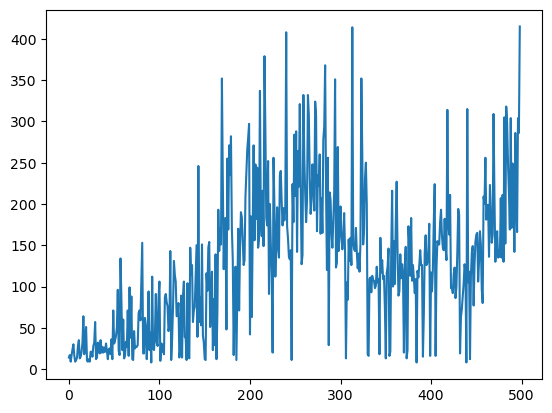

In [13]:
import matplotlib.pyplot as plt
plt.plot(scores)

In [14]:
# Test
env = gym.make('CartPole-v1') # no visualization

# Test
test_episodes = 30
test_scores = []
start_time = time.time()

for e in range(test_episodes):
    state, done = env.reset()
    state = np.reshape(state, [1, state_size])

    for t in range(501):
        action = np.argmax(agent.model.predict(state, verbose = 0)[0])
        state, reward, done, info, _ = env.step(action)
        state = np.reshape(state, [1, state_size])
    

        if done or t == 500:
            print("Test Episode: {}/{}, Score: {}".format(e + 1, test_episodes, t))
            test_scores.append(t)
            break

test_average = mean(test_scores)
test_sigma = stdev(test_scores)
end_time = time.time()
total_time = end_time - start_time
total_steps = sum(test_scores)
average_time_per_step = total_time / total_steps

print()
print('Score average: {:.2f}, Sigma: {:.2f}'.format(test_average, test_sigma))
print('Average time per step: {:.4f} seconds'.format(average_time_per_step))

env.close()

/opt/homebrew/Caskroom/miniforge/base/envs/test_2/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Test Episode: 1/30, Score: 189
Test Episode: 2/30, Score: 156
Test Episode: 3/30, Score: 147
Test Episode: 4/30, Score: 191
Test Episode: 5/30, Score: 167
Test Episode: 6/30, Score: 187
Test Episode: 7/30, Score: 191
Test Episode: 8/30, Score: 164
Test Episode: 9/30, Score: 239
Test Episode: 10/30, Score: 215
Test Episode: 11/30, Score: 156
Test Episode: 12/30, Score: 188
Test Episode: 13/30, Score: 176
Test Episode: 14/30, Score: 152
Test Episode: 15/30, Score: 134
Test Episode: 16/30, Score: 161
Test Episode: 17/30, Score: 153
Test Episode: 18/30, Score: 306
Test Episode: 19/30, Score: 162
Test Episode: 20/30, Score: 164
Test Episode: 21/30, Score: 150
Test Episode: 22/30, Score: 192
Test Episode: 23/30, Score: 157
Test Episode: 24/30, Score: 160
Test Episode: 25/30, Score: 152
Test Episode: 26/30, Score: 148
Test Episode: 27/30, Score: 180
Test Episode: 28/30, Score: 160
Test Episode: 29/30, Score: 181
Test Episode: 30/30, Score: 180

Score average: 175.27, Sigma: 33.10
Average time

## Record the video

In [15]:
from moviepy.editor import ImageSequenceClip

# Load the cartpole environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Visualization and video creation
def save_video():
    frames = []

    state, done = env.reset()
    for t in range(501):
        pixels = env.render()
        frames.append(pixels)

        state = np.reshape(state, [1, state_size])
        action = np.argmax(agent.model.predict(state, verbose = 0)[0])
        state, reward, done, info, _ = env.step(action)

        if done or t == 500:
            break

    # Save the frames as a video
    clip = ImageSequenceClip(frames, fps=50)
    clip.write_videofile("video/DQN_gym_balance.mp4", codec="libx264")

# Call the save_video function with your policy function
save_video()

env.close()

Moviepy - Building video video/DQN_gym_balance.mp4.
Moviepy - Writing video video/DQN_gym_balance.mp4



Moviepy - Done !
Moviepy - video ready video/DQN_gym_balance.mp4


this works for the cartpole gym environement as the input is discrete: 0 or 1. The DQN-network does work fine for this. even though i'm not sure why the improvement is stopping after a while and acctually getting worse. maybe the NN is too small?

anyways for this to work with the dm_control library, i need to make i work for a continous force input. and there another algorithm is necessary. 

## Comparison with DQN from Stablebaselines 3

In [4]:
import gym
from gym import Wrapper
import numpy as np

class CartPoleWrapper(Wrapper):
    def reset(self):
        observation, done = self.env.reset()
        return np.array(observation)

    def step(self, action):
        observation, reward, done, info, _ = self.env.step(action)
        info = {'episode': done}
        return np.array(observation), reward, done, info
    def render(self):
        self.env.render()

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

# Create the custom wrapped environment
env = gym.make('CartPole-v1')
#env =gym.make('CartPole-v1', render_mode="human")
env = CartPoleWrapper(env)

# Define the DQN model
model = DQN(
    'MlpPolicy',
    env,
    learning_rate=1e-3,
    buffer_size=100000,
    learning_starts=1000,
    batch_size=64,
    tau=1.0,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    optimize_memory_usage=False,
    target_update_interval=1000,
    exploration_fraction=0.1,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    max_grad_norm=10,
    tensorboard_log=None,
    create_eval_env=False,
    policy_kwargs=None,
    verbose=1,
    seed=None,
    device='auto',
    _init_setup_model=True
)

# Train the DQN model
model.learn(total_timesteps=100000, log_interval=1000)

# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")


# Save the trained model
model.save('dqn_cartpole')

# Load the trained model and test it
loaded_model = DQN.load('dqn_cartpole', env=env)

obs = env.reset()
for t in range(1000):
    action, _states = loaded_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones or t == 500:
            print(t)
            break

env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/homebrew/Caskroom/miniforge/base/envs/test_2/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [ ]:
# information about the model
print("Policy network architecture:", model.policy)

In [9]:
# Test
env = gym.make('CartPole-v1') # no visualization

# Test
test_episodes = 30
test_scores = []
start_time = time.time()

for e in range(test_episodes):
    state, done = env.reset()
    state = np.reshape(state, [1, state_size])

    for t in range(501):
        action = model.predict(state)[0][0]
        state, reward, done, info, _ = env.step(action)
        state = np.reshape(state, [1, state_size])
    

        if done or t == 500:
            print("Test Episode: {}/{}, Score: {}".format(e + 1, test_episodes, t))
            test_scores.append(t)
            break

test_average = mean(test_scores)
test_sigma = stdev(test_scores)
end_time = time.time()
total_time = end_time - start_time
total_steps = sum(test_scores)
average_time_per_step = total_time / total_steps

print()
print('Score average: {:.2f}, Sigma: {:.2f}'.format(test_average, test_sigma))
print('Average time per step: {:.4f} seconds'.format(average_time_per_step))

env.close()

Test Episode: 1/30, Score: 374
Test Episode: 2/30, Score: 368
Test Episode: 3/30, Score: 376
Test Episode: 4/30, Score: 374
Test Episode: 5/30, Score: 368
Test Episode: 6/30, Score: 369
Test Episode: 7/30, Score: 360
Test Episode: 8/30, Score: 374
Test Episode: 9/30, Score: 384
Test Episode: 10/30, Score: 373
Test Episode: 11/30, Score: 377
Test Episode: 12/30, Score: 374
Test Episode: 13/30, Score: 385
Test Episode: 14/30, Score: 368
Test Episode: 15/30, Score: 368
Test Episode: 16/30, Score: 373
Test Episode: 17/30, Score: 379
Test Episode: 18/30, Score: 361
Test Episode: 19/30, Score: 393
Test Episode: 20/30, Score: 377
Test Episode: 21/30, Score: 373
Test Episode: 22/30, Score: 397
Test Episode: 23/30, Score: 382
Test Episode: 24/30, Score: 380
Test Episode: 25/30, Score: 361
Test Episode: 26/30, Score: 384
Test Episode: 27/30, Score: 398
Test Episode: 28/30, Score: 365
Test Episode: 29/30, Score: 368
Test Episode: 30/30, Score: 360

Score average: 374.77, Sigma: 10.06
Average time

In [10]:
from moviepy.editor import ImageSequenceClip

# Load the cartpole environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Visualization and video creation
def save_video():
    frames = []

    state, done = env.reset()
    for t in range(501):
        pixels = env.render()
        frames.append(pixels)

        state = np.reshape(state, [1, state_size])
        action = model.predict(state)[0][0]
        state, reward, done, info, _ = env.step(action)

        if done or t == 500:
            break

    # Save the frames as a video
    clip = ImageSequenceClip(frames, fps=50)
    clip.write_videofile("video/DQN_sb3_gym_balance.mp4", codec="libx264")

# Call the save_video function with your policy function
save_video()

env.close()

Moviepy - Building video video/DQN_PPO_gym_balance.mp4.
Moviepy - Writing video video/DQN_PPO_gym_balance.mp4



Moviepy - Done !
Moviepy - video ready video/DQN_PPO_gym_balance.mp4
